In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import os

import numpy as np
import pandas as pd
import tensorflow as tf

import atecml.data

from contextlib import contextmanager
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegressionCV
#build Models...
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
from imblearn.over_sampling import SMOTE, ADASYN
import random

plt.style.use('ggplot')

In [139]:
def lgb_modelfit_nocv(params, dtrain, dvalid, predictors, target='target', objective='binary', metrics='binary_error',
                 feval=None, early_stopping_rounds=20, num_boost_round=3000, verbose_eval=10, categorical_features=None):
    lgb_params = {
        'boosting_type': 'dart',
        #'drop_rate' : 0.2, #Dart Only, DropoutRate
        'objective': objective,
        'use_missing' : 'true',
        'learning_rate': 0.15,
        'is_unbalance': 'true',  #because training data is unbalance (replaced with scale_pos_weight)
        'num_leaves': 64,  # we should let it be smaller than 2^(max_depth)
        'max_depth': -1,  # -1 means no limit
        'min_child_samples': 600,  # Minimum number of data need in a child(min_data_in_leaf)
        'max_bin': 255,  # Number of bucketed bin for feature values
        'feature_fraction': 0.35,
        'subsample': 0.7,  # Subsample ratio of the training instance.
        'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
        'min_child_weight': 0.05,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
        'subsample_for_bin': 200000,  # Number of samples for constructing bin
        'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
        'reg_alpha': 5,  # L1 regularization term on weights
        'reg_lambda': 10,  # L2 regularization term on weights
        'nthread': 40,
        'verbose': 0,
        'metric':metrics
    }

    lgb_params.update(params)
    print("preparing validation datasets")

    xgtrain = lgb.Dataset(dtrain[predictors].values, label=dtrain[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical_features
                          )
    xgvalid = lgb.Dataset(dvalid[predictors].values, label=dvalid[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical_features
                          )

    evals_results = {}

    bst1 = lgb.train(lgb_params, 
                     xgtrain, 
                     valid_sets=[xgtrain, xgvalid], 
                     valid_names=['train','valid'], 
                     evals_result=evals_results, 
                     num_boost_round=num_boost_round,
                     early_stopping_rounds=early_stopping_rounds,
                     verbose_eval=10, 
                     feval=feval)

    n_estimators = bst1.best_iteration
    print("\nModel Report")
    print("n_estimators : ", n_estimators)
    #print(metrics+":", evals_results['valid'][metrics][n_estimators-1])    
    return bst1

def model_validation(train_df,val_df,predictors,target,params):
    categorical = ['f5']
    bst = lgb_modelfit_nocv(params, 
                        train_df, 
                        val_df, 
                        predictors, 
                        target, 
                        objective='binary', 
                        metrics='auc',
                        early_stopping_rounds=100, 
                        verbose_eval=30, 
                        num_boost_round=5000, 
                        categorical_features=categorical)
    y_predict = bst.predict(val_df[predictors])
    if (target == 'Normal'):
        y_predict = 1 - y_predict
    atec_Score,b,c=atecml.data.accuracy_validation(val_df['Fraud'],y_predict)
    return bst,atec_Score

# 不做Fillna和oversample处理

In [140]:
data = atecml.data.load_train()
train_df = atecml.data.filter_date(data,start_date='2017-09-15',end_date='2017-09-22')
val_df = atecml.data.filter_date(data,start_date='2017-09-23',end_date='2018-09-24')

predictors = [x for x in train_df.columns if x not in atecml.data.NOT_FEATURE_SUM]

## 欺诈判断

preparing validation datasets
Training until validation scores don't improve for 100 rounds.
[10]	train's auc: 0.986171	valid's auc: 0.960418
[20]	train's auc: 0.98983	valid's auc: 0.968555
[30]	train's auc: 0.991961	valid's auc: 0.971641
[40]	train's auc: 0.993259	valid's auc: 0.97287
[50]	train's auc: 0.99366	valid's auc: 0.973953
[60]	train's auc: 0.99435	valid's auc: 0.973626
[70]	train's auc: 0.994741	valid's auc: 0.975574
[80]	train's auc: 0.995069	valid's auc: 0.975458
[90]	train's auc: 0.995187	valid's auc: 0.975237
[100]	train's auc: 0.995457	valid's auc: 0.975377
[110]	train's auc: 0.99546	valid's auc: 0.975667
[120]	train's auc: 0.995699	valid's auc: 0.975255
[130]	train's auc: 0.995816	valid's auc: 0.975028
[140]	train's auc: 0.996046	valid's auc: 0.974679
[150]	train's auc: 0.996213	valid's auc: 0.97505
[160]	train's auc: 0.996173	valid's auc: 0.974768
[170]	train's auc: 0.996495	valid's auc: 0.974798
Early stopping, best iteration is:
[78]	train's auc: 0.994971	valid's au

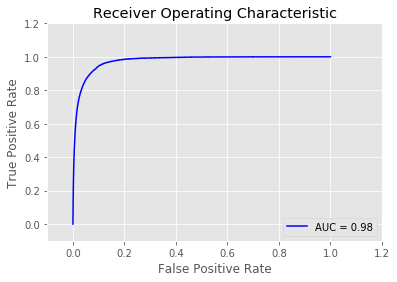

preparing validation datasets
Training until validation scores don't improve for 100 rounds.
[10]	train's auc: 0.97704	valid's auc: 0.95198
[20]	train's auc: 0.982477	valid's auc: 0.96124
[30]	train's auc: 0.986016	valid's auc: 0.964544
[40]	train's auc: 0.988182	valid's auc: 0.966567
[50]	train's auc: 0.989359	valid's auc: 0.967739
[60]	train's auc: 0.990347	valid's auc: 0.967857
[70]	train's auc: 0.991043	valid's auc: 0.969029
[80]	train's auc: 0.991546	valid's auc: 0.968974
[90]	train's auc: 0.991798	valid's auc: 0.968932
[100]	train's auc: 0.992175	valid's auc: 0.969047
[110]	train's auc: 0.992257	valid's auc: 0.969413
[120]	train's auc: 0.99271	valid's auc: 0.969183
[130]	train's auc: 0.99304	valid's auc: 0.96891
[140]	train's auc: 0.993307	valid's auc: 0.968725
[150]	train's auc: 0.993581	valid's auc: 0.969161
[160]	train's auc: 0.993537	valid's auc: 0.969051
[170]	train's auc: 0.994007	valid's auc: 0.968684
[180]	train's auc: 0.99425	valid's auc: 0.968695
[190]	train's auc: 0.99

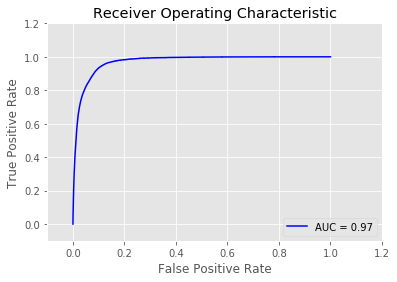

In [141]:
params = {
    'save_binary': 'true'
    #'colsample_bytree': 0.9,
    #'min_child_weight': 0,
    #'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
    #'max_bin': 100,  # Number of bucketed bin for feature values
    #'subsample': 0.7,  # Subsample ratio of the training instance.
    #'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
}

model_neg,score_neg = model_validation(train_df,val_df,predictors,'Fraud',params)
model_pos,score_pos = model_validation(train_df,val_df,predictors,'Normal',params)

In [142]:
print("Pos-Atec-Score:",score_pos)
print("Neg-Atec-Score:",score_neg)

Pos-Atec-Score: 0.27042788879235446
Neg-Atec-Score: 0.37587966985230237


# Optimization

In [87]:
from sklearn.metrics import roc_auc_score,roc_curve,auc
from skopt.space import Real, Integer
from skopt.utils import use_named_args
import itertools
from skopt import gp_minimize
import gc

data = atecml.data.load_train()
train_df = atecml.data.filter_date(data,start_date='2017-09-01',end_date='2017-10-15')
val_df = atecml.data.filter_date(data,start_date='2017-10-16',end_date='2018-10-15')
target='Fraud'
predictors = [x for x in train_df.columns if x not in atecml.data.NOT_FEATURE_SUM]

# from that dimension (`'log-uniform'` for the learning rate)
space  = [Integer(3, 10, name='max_depth'),
          Integer(6, 30, name='num_leaves'),
          Integer(50, 1500, name='min_child_samples'),
          Real(0.3, 1,  name='feature_fraction'),
          Real(0.6, 0.9, name='subsample'),
         ]


In [101]:
def objective(values):

    params = {'max_depth': values[0], 
        'num_leaves': values[1], 
        'min_child_samples': values[2], 
        'feature_fraction': values[3],
        'subsample': values[4],
        'boosting_type': 'dart',
        #'drop_rate' : 0.2, #Dart Only, DropoutRate
        'objective': 'binary',
        'use_missing' : 'true',
        'learning_rate': 0.1,
        'is_unbalance': 'true',  #because training data is unbalance (replaced with scale_pos_weight)
        'max_bin': 64,  # Number of bucketed bin for feature values
        'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
        'min_child_weight': 5,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
        'subsample_for_bin': 200000,  # Number of samples for constructing bin
        'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
        'reg_alpha': 5,  # L1 regularization term on weights
        'reg_lambda': 10,  # L2 regularization term on weights
        'nthread': -1,
        'verbose': 0,
        'metric':'auc'
        }
    

    print('\nNext set of params.....',params)
    
    categorical = ['f5']
    
    
    early_stopping_rounds = 50
    num_boost_round       = 1000
    
        # Fit model on feature_set and calculate validation AUROC
    xgtrain = lgb.Dataset(train_df[predictors].values, label=train_df[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical
                          )
    xgvalid = lgb.Dataset(val_df[predictors].values, label=val_df[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical
                          )
    
    evals_results = {}
    model_lgb     = lgb.train(params,xgtrain,valid_sets=[xgtrain, xgvalid], 
                              valid_names=['train','valid'], 
                               evals_result=evals_results, 
                               num_boost_round=num_boost_round,
                                early_stopping_rounds=early_stopping_rounds,
                               verbose_eval=None, feval=None)
    
    y_test = val_df[target].values
    y_pred = model_lgb.predict(val_df[predictors])
    
    fpr, tpr, thresholds  = roc_curve(y_test,y_pred)
    roc_auc = auc(fpr, tpr)
    roc_result = pd.DataFrame()
    roc_result['fpr'] = pd.Series(fpr)
    roc_result['tpr'] = pd.Series(tpr)
    roc_result['thresholds'] = pd.Series(thresholds)
    TPR1= float(roc_result[roc_result['fpr']<=0.001002].tail(1)['tpr'])
    TPR2=float(roc_result[roc_result['fpr']<=0.005002].tail(1)['tpr'])
    TPR3=float(roc_result[roc_result['fpr']<=0.010002].tail(1)['tpr'])
    ATEC_SCORE = -(0.4*TPR1 + 0.3*TPR2 + 0.3 * TPR3)
    
    print('\nAUC.....',roc_auc,"Atec-Score",-ATEC_SCORE,".....iter.....", model_lgb.current_iteration())
    
    gc.collect()
    
    return  ATEC_SCORE


In [90]:
res_gp = gp_minimize(objective, space, n_calls=10, random_state=0,n_random_starts=10)


Next set of params..... {'reg_alpha': 0.5, 'metric': 'auc', 'objective': 'binary', 'min_split_gain': 0, 'max_bin': 255, 'nthread': -1, 'is_unbalance': 'true', 'min_child_samples': 693, 'subsample_freq': 1, 'use_missing': 'true', 'min_child_weight': 5, 'learning_rate': 0.15, 'feature_fraction': 0.893076217148888, 'max_depth': 7, 'boosting_type': 'dart', 'num_leaves': 26, 'subsample_for_bin': 2000, 'subsample': 0.7870691090357917, 'reg_lambda': 0.1}

AUC..... 0.9852311398533866 Atec-Score 0.4783092324805339 .....iter..... 317

Next set of params..... {'reg_alpha': 0.5, 'metric': 'auc', 'objective': 'binary', 'min_split_gain': 0, 'max_bin': 255, 'nthread': -1, 'is_unbalance': 'true', 'min_child_samples': 93, 'subsample_freq': 1, 'use_missing': 'true', 'min_child_weight': 5, 'learning_rate': 0.15, 'feature_fraction': 0.49085940620607926, 'max_depth': 6, 'boosting_type': 'dart', 'num_leaves': 13, 'subsample_for_bin': 2000, 'subsample': 0.743299535196405, 'reg_lambda': 0.1}

AUC..... 0.9828

In [104]:
print(res_gp.x)

[6, 25, 440, 0.7752156710832723, 0.8161897964177751]


# 按照日期来填充每日的中位数和SMOTE过采样gcForest

In [ ]:
config = {}
ca_config = {}
ca_config["random_state"] = 0
ca_config["max_layers"] = 100
ca_config["early_stopping_rounds"] = 3
ca_config["n_classes"] = 10
ca_config["estimators"] = []
ca_config["estimators"].append(
        {"n_folds": 5, "type": "XGBClassifier", "n_estimators": 10, "max_depth": 5,
         "objective": "multi:softprob", "silent": True, "nthread": -1, "learning_rate": 0.1} )
ca_config["estimators"].append({"n_folds": 5, "type": "RandomForestClassifier", "n_estimators": 10, "max_depth": None, "n_jobs": -1})
ca_config["estimators"].append({"n_folds": 5, "type": "ExtraTreesClassifier", "n_estimators": 10, "max_depth": None, "n_jobs": -1})
ca_config["estimators"].append({"n_folds": 5, "type": "LogisticRegression"})
config["cascade"] = ca_config


In [ ]:
X_train_enc = gc.fit_transform(X_train, y_train)
# X_enc is the concatenated predict_proba result of each estimators of the last layer of the GCForest model
# X_enc.shape =
#   (n_datas, n_estimators * n_classes): If cascade is provided
#   (n_datas, n_estimators * n_classes, dimX, dimY): If only finegrained part is provided
# You can also pass X_test, y_test to fit_transform method, then the accracy on test data will be logged when training.
# X_train_enc, X_test_enc = gc.fit_transform(X_train, y_train, X_test=X_test, y_test=y_test)
# WARNING: if you set gc.set_keep_model_in_mem(True), you would have to use
# gc.fit_transform(X_train, y_train, X_test=X_test, y_test=y_test) to evaluate your model.

y_pred = gc.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Test Accuracy of GcForest = {:.2f} %".format(acc * 100))

# You can try passing X_enc to another classfier on top of gcForest.e.g. xgboost/RF.
X_test_enc = gc.transform(X_test)
X_train_enc = X_train_enc.reshape((X_train_enc.shape[0], -1))
X_test_enc = X_test_enc.reshape((X_test_enc.shape[0], -1))
X_train_origin = X_train.reshape((X_train.shape[0], -1))
X_test_origin = X_test.reshape((X_test.shape[0], -1))
X_train_enc = np.hstack((X_train_origin, X_train_enc))
X_test_enc = np.hstack((X_test_origin, X_test_enc))
print("X_train_enc.shape={}, X_test_enc.shape={}".format(X_train_enc.shape, X_test_enc.shape))
clf = RandomForestClassifier(n_estimators=1000, max_depth=None, n_jobs=-1)
clf.fit(X_train_enc, y_train)
y_pred = clf.predict(X_test_enc)
acc = accuracy_score(y_test, y_pred)
print("Test Accuracy of Other classifier using gcforest's X_encode = {:.2f} %".format(acc * 100))


In [ ]:
fi = pd.DataFrame()
fi['imp']= clf1.feature_importances_
fi['feature'] = predictors
fi.sort_values('imp',ascending=False)